In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm
import cv2
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.utils.vis_utils import plot_model

In [139]:
labels = ["cats", "dogs"]
classlabels = {labels: i for i, labels in enumerate(labels)}

In [140]:
print(classlabels)

{'cats': 0, 'dogs': 1}


## Visualization

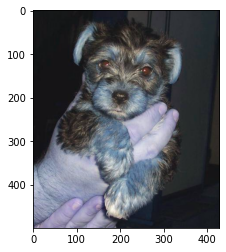

In [104]:
# H/W -- Split the file name and extrat the class names 
imageData = cv2.imread("../input/dogcat-cnn-dataset/Convolutional_Neural_Networks/dataset/test_set/dogs/dog.4002.jpg")
plt.imshow(imageData)
plt.show()

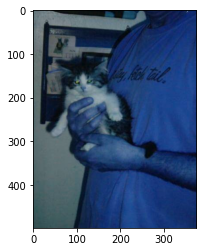

In [105]:
imageData = cv2.imread("../input/dogcat-cnn-dataset/Convolutional_Neural_Networks/dataset/test_set/cats/cat.4002.jpg")
plt.imshow(imageData)
plt.show()

In [106]:
#Free Memory using gc.collect()
gc.collect()

14715

In [107]:
image_shape=28

## Loading Dataset

In [125]:
def datasetLoaderFromDirectory():
        dataset_path = ["../input/dogcat-cnn-dataset/Convolutional_Neural_Networks/dataset/training_set/", "../input/dogcat-cnn-dataset/Convolutional_Neural_Networks/dataset/test_set/"]
        imageataOutput = []
        
        for i in dataset_path:
            images = []
            labels = []
            print("Counting : {}".format(i))
            
            for j in os.listdir(i):
                label = classNameslabels[j]
               
                for imagedatafile in tqdm(os.listdir(os.path.join(i, j))):
                
                    imagePath = os.path.join(os.path.join(i, j), imagedatafile)
                
                    image = cv2.imread(imagePath)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image,(image_shape,image_shape))
                                
                    images.append(image)
                    labels.append(label)
            images = np.array(images)
            labels = np.array(labels)
            #print(images)
            imageataOutput.append((images, labels))
    
        return imageataOutput
                

In [126]:
(train_image, train_labels), (test_image, test_labels) = datasetLoaderFromDirectory()

Counting : ../input/dogcat-cnn-dataset/Convolutional_Neural_Networks/dataset/training_set/


100%|██████████| 4000/4000 [00:13<00:00, 290.11it/s]


Counting : ../input/dogcat-cnn-dataset/Convolutional_Neural_Networks/dataset/test_set/


100%|██████████| 1000/1000 [00:03<00:00, 274.99it/s]


In [127]:
train_image, train_labels = shuffle(train_image, train_labels, random_state = 42)

In [128]:
train_image = train_image/255.0
test_image = test_image/255.0

In [129]:
train_image.shape

(8000, 28, 28, 3)

In [130]:
test_image.shape

(2000, 28, 28, 3)

In [131]:
train_labels.shape

(8000,)

In [138]:
train_labels

array([1, 1, 1, ..., 1, 0, 0])

In [132]:
test_labels.shape

(2000,)

## create Dataframe

In [133]:
_, trainImageLabelInfo = np.unique(train_labels, return_counts=True)
_, testImageLabelInfo = np.unique(test_labels, return_counts = True)

In [134]:
print("Train Image Label information for 0 Class: ", trainImageLabelInfo[0])
print("Train Image Label information for 1 Class: ", trainImageLabelInfo[1])




print("---------------------------------------------------")

print("Test Image Label information for 0 Class: ", testImageLabelInfo[0])
print("Test Image Label information for 1 Class: ", testImageLabelInfo[1])

Train Image Label information for 0 Class:  4000
Train Image Label information for 1 Class:  4000
---------------------------------------------------
Test Image Label information for 0 Class:  1000
Test Image Label information for 1 Class:  1000


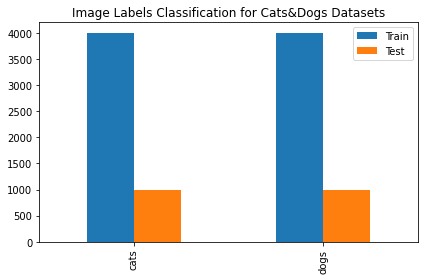

In [135]:
pd.DataFrame({"Train":trainImageLabelInfo,
            "Test": testImageLabelInfo}, 
             index = labels
            ).plot.bar()
# plt.plot()
# plt.bar()
plt.title("Image Labels Classification for Cats&Dogs Datasets")
plt.grid(False)
plt.tight_layout()
plt.show()

In [145]:
label_Encoder = LabelEncoder()
#label_Encoder = preprocessing.LabelEncoder
ytrain = label_Encoder.fit_transform(train_labels)
ytest = label_Encoder.fit_transform(test_labels)


In [146]:
#OneHotEncoder for train dataset
labelEncoderValue=ytrain.reshape(len(ytrain),1)
ohe=OneHotEncoder(sparse=False)
Ytrain=ohe.fit_transform(labelEncoderValue)

In [148]:
#OneHotEncoder for test dataset
labelEncoderValue=ytest.reshape(len(ytest),1)
ohe=OneHotEncoder(sparse=False)
y_test=ohe.fit_transform(labelEncoderValue)

In [149]:
Ytrain.shape

(8000, 2)

In [150]:
y_test.shape

(2000, 2)

In [20]:
ytrain.shape

(8000, 2)

## LeNet Implementation

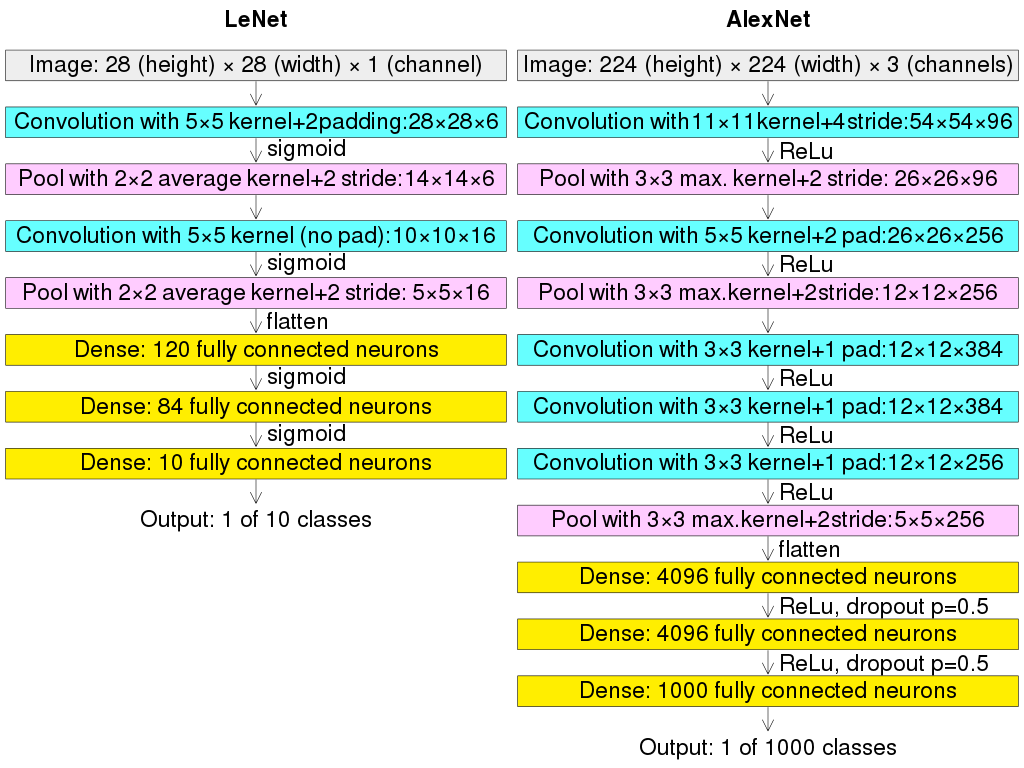

In [156]:
model = Sequential() # Empty 

# 1st layer
model.add(Conv2D(6,kernel_size = (5, 5), strides = (1, 1), activation = "relu", input_shape = (28, 28, 3), padding = "same"))
model.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

# 2nd Layer
model.add(Conv2D(16,kernel_size = (5, 5), strides = (1, 1), activation = "relu", padding = "valid"))
model.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

# Flatten Layer
model.add(Flatten())

# Output Layer
model.add(Dense(120, activation = "relu"))
model.add(Dense(84, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [157]:
model.compile(optimizer = "adam",
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [158]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
average_pooling2d_8 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_9 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_13 (Dense)             (None, 84)               

In [159]:
tensorboard=TensorBoard(log_dir="logs")
checkpoint=ModelCheckpoint("LeNet.h5",
                          monitor='val_accuracy',
                          mode="auto",
                          verbose=1,
                          save_best_only=True
                          )

reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',
                           factor=0.1,
                            patience=10,
                            min_delta=0.001,
                            mode="auto",
                            verbose=1
                           )
earlyStopping = EarlyStopping(monitor='val_acc',
                             patience=5,
                             verbose=1,
                             mode='auto')

2022-09-17 07:15:25.948894: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-17 07:15:25.948967: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-17 07:15:25.949302: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [160]:
history = model.fit(train_image, 
                   Ytrain,
                   batch_size=32,
                   epochs=50,
                   verbose=1, 
                   validation_split=0.2,
                   callbacks=[tensorboard, checkpoint, reduce_LR, earlyStopping]
                   )

Epoch 1/50
 18/200 [=>............................] - ETA: 1s - loss: 0.7050 - accuracy: 0.4844

2022-09-17 07:15:27.883792: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-17 07:15:27.884119: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-17 07:15:27.930258: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-17 07:15:27.931608: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-17 07:15:27.933281: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_09_17_07_15_27

2022-09-17 07:15:27.934260: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_09_17_07_15_27/9c833941543e.trace.json.gz
2022-09-17 07:15:27.936961: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_09_17_07_15_27

2022-09-17 07:15:27.937523: I

200/200 [==============================] - 3s 12ms/step - loss: 0.6892 - accuracy: 0.5255 - val_loss: 0.6602 - val_accuracy: 0.6100

Epoch 00001: val_accuracy improved from -inf to 0.61000, saving model to LeNet.h5
Epoch 2/50
200/200 [==============================] - 2s 9ms/step - loss: 0.6476 - accuracy: 0.6242 - val_loss: 0.6636 - val_accuracy: 0.6225

Epoch 00002: val_accuracy improved from 0.61000 to 0.62250, saving model to LeNet.h5
Epoch 3/50
200/200 [==============================] - 2s 8ms/step - loss: 0.6194 - accuracy: 0.6559 - val_loss: 0.6123 - val_accuracy: 0.6475

Epoch 00003: val_accuracy improved from 0.62250 to 0.64750, saving model to LeNet.h5
Epoch 4/50
200/200 [==============================] - 2s 8ms/step - loss: 0.5934 - accuracy: 0.6819 - val_loss: 0.6086 - val_accuracy: 0.6831

Epoch 00004: val_accuracy improved from 0.64750 to 0.68313, saving model to LeNet.h5
Epoch 5/50
200/200 [==============================] - 2s 8ms/step - loss: 0.5774 - accuracy: 0.6956 -

In [163]:
pred=model.predict(test_image)

In [164]:
score=model.evaluate(test_image,y_test)

63/63 [==============================] - 0s 3ms/step - loss: 1.3804 - accuracy: 0.7045


## Draw Classification Matrix

In [165]:
pred=np.argmax(pred,axis=1)
ytest=np.argmax(y_test,axis=1)
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1000
           1       0.71      0.70      0.70      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



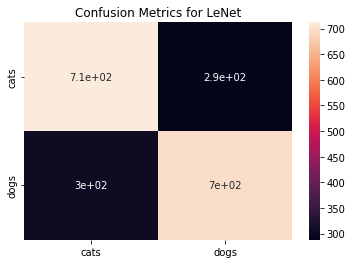

In [166]:
Cm=confusion_matrix(ytest,pred)
ax=plt.axes()
sns.heatmap(Cm, annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
            yticklabels=labels,
            ax=ax
           )

plt.title("Confusion Metrics for LeNet")
plt.show()

In [167]:
def accuracy_and_loss_Plot(modelData):
    
    fig=plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title(" Accuracy Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Loss Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

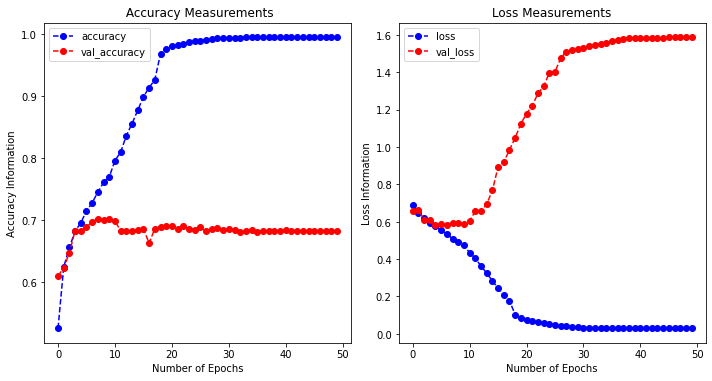

In [168]:
accuracy_and_loss_Plot(history)